# Extractor.py Notebook


## Functions

In [370]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import xarray as xr
import os
from pyproj import Transformer
from datetime import datetime, timedelta

from helpers import *

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, WheelZoomTool, BoxZoomTool, ResetTool, PanTool
from bokeh.io import output_notebook
from bokeh.tile_providers import OSM, get_provider

from lxml import html
import requests

In [371]:
def checkDates(time1,time2):
    time_start = datetime(int(time1[:4]), int(time1[4:6]), int(time1[6:]))
    time_end = datetime(int(time2[:4]), int(time2[4:6]), int(time2[6:]))
    assert time_start < time_end, 'ERROR: time1 cannot be after time2, please check.'
    
    year1 = int(time1[:4])
    year2 = int(time2[:4])
    time_str = f'{time1}-{time2}'
    
    if year1==year2: sameyear = True
    else: sameyear = False
    
    return time_start, time_end, year1, year2, time_str, sameyear

In [387]:
def checkParams(depth, bbox, time1, time2, vars_sel, group, formats):
    # Define Global Variables
    global time_start, time_end, time_str, year1, year2, sameyear, bbox_g, bbox_str, depth_g, vars_g, group_g, formats_g
     
    # Check dates
    time_start, time_end, year1, year2, time_str, sameyear = checkDates(time1,time2)
    print('Time Range:', time_str)
    print('Same Year flag:', sameyear)

    # Check BBOX
    bbox_g = [int(bb) for bb in bbox.split(',')]
    bbox_str = '.'.join([str(b) for b in bbox_g])
    print('Bounding Box:', bbox_g) #, bbox_str)

    # Check depth
    depth_g = depth
    print(f'Depth: {depth_g}m')

    vars_g = vars_sel
    print('Vars:', vars_g)

    group_g = group
    print('Separate files per Var:', group_g)

    formats_g = []
    if 'csv' in formats: formats_g.append('CSV')
    if 'netcdf4' in formats: formats_g.append('NetCDF4')
    print('Output files format(s):', formats_g)
    assert len(formats_g) > 0, 'ERROR: Output file format entered is wrong. It must be "csv", "netcdf4", or "csv,netcdf4".'

In [373]:
def getDDS(url_info, year):
    # Get dds info, and assign max dimensions to TIME and DEPTH
    
    pc_dim_dict = {}
    time_stop_dict = {}
    depth_stop_dict = {}

    # get all content of the server_url, and then filter it with year and available platforms
    page = requests.get(url_info[0])
    webpage = html.fromstring(page.content)
    
    urls_filtered = [p for p in webpage.xpath('//a/@href') if p.endswith(f'{year}.nc{url_info[1]}.dds')]

    for u in urls_filtered:

        dds = f'{url_info[0]}/{u}'#; print(dds)

        # Find platform code
        if len(url_info[1]) == 0: pc = dds.split('_')[0][-2:] # nmdc case
        else: pc = dds.split('_')[1][-2:] # t2_hyrax case

        pc_dim_dict[pc] = retrieveDDSinfo(dds)

        time_stop_dict[pc] = pc_dim_dict[pc]['TIME']
        depth_stop_dict[pc] = pc_dim_dict[pc]['DEPTH']

    assert depth_stop_dict.keys() == time_stop_dict.keys(), 'TIME and DEPTH Keys error. Please check.'
    
    return pc_dim_dict


In [375]:
def getPositionDict(pc_dim_dict, url_info, year):
    # Extract data and create position_dict
    
    position_dict = {}
    
    for pc in pc_dim_dict.keys():

        coords_str = getQueryString(pc_dim_dict[pc], keylist = ['TIME', 'LATITUDE', 'LONGITUDE']) 

        fix_lab = f'58{pc}_CTD_{year}' # label to use for this campaign

        url = f'{url_info[0]}{fix_lab}.nc{url_info[1]}?{coords_str}'; print(f'Platform: {pc}. URL with Queries:', url)

        remote_data, data_attr = fetch_data(url, year)

        position_dict[pc] = {'data': remote_data, 
                             'data_attr': data_attr}
#     print(position_dict)    
    
    return position_dict


In [376]:
def makePositionDF(position_dict):
    # Load locations (LONG & LAT) and TIME of all measurements in a position_df_raw (includes duplicates)

    position_df_raw = pd.DataFrame() 

    for key in position_dict.keys():
        test = pd.DataFrame()
    
        test['Longitude_WGS84'] = position_dict[key]['data']['LONGITUDE'].data.astype(float)
        test['Latitude_WGS84'] = position_dict[key]['data']['LATITUDE'].data.astype(float)
        test['Time'] = position_dict[key]['data']['TIME'].data.astype(float)
        test['Platform'] = key

        # Convert TIME from float to datetime
        test['Time'] = [start_date + timedelta(t) for t in test.loc[:,'Time']]
        length = len(test[test['Platform']==key])
        print(f'Platform {key}: {length} measurement locations.')
        
        position_df_raw = position_df_raw.append(test) 
    
    position_df_raw['Index_ABS'] = np.arange(0,len(position_df_raw))
    position_df_raw = position_df_raw.rename_axis("Index_Relative")

    # Now remove duplicates
    duplicates = position_df_raw[position_df_raw.duplicated(subset='Time') == True]
    
    position_df_temp = position_df_raw.drop_duplicates(subset=['Time'])
    
    print(f'Merged dataframe with all platforms. Total of {len(position_df_raw)} measurement positions')
    print(f'Duplicates: \t{len(duplicates)} / {len(position_df_raw)} \nRemaining: \t{len(position_df_temp)} / {len(position_df_raw)}')
    
    return position_df_temp

In [377]:
def filterBBOXandTIME(position_df, time1, time2):
    # Filter the position_df dataframe by BBOX
    position_df_bbox = position_df[(position_df.loc[:,'Longitude_WGS84'] >= bbox_g[0]) & 
                                   (position_df.loc[:,'Longitude_WGS84'] <= bbox_g[1]) & 
                                   (position_df.loc[:,'Latitude_WGS84'] >= bbox_g[2]) & 
                                   (position_df.loc[:,'Latitude_WGS84'] <= bbox_g[3])]

    # Print filtering results on original dataframe
    global sel_outof_all
    sel_outof_all = f'{len(position_df_bbox)} out of {len(position_df)}.'
#     print(f'Selected positions (out of available positions): {sel_outof_all}')
#     print(position_df_bbox)

    # Filter the position_df_bbox dataframe by TIME
    position_df_bbox_timerange = position_df_bbox.loc[(position_df_bbox['Time']>=time_start) & 
                                                      (position_df_bbox['Time']<=time_end)]

    # Print filtering results on original dataframe
    print(f'\nUser-defined Time Range: {time_str}')
    sel_outof_all = f'{len(position_df_bbox_timerange)} out of {len(position_df)}.'
    print(f'Selected positions (out of available positions): {sel_outof_all}')

    # print(position_df_bbox_timerange)
    
    return position_df_bbox_timerange


In [378]:
def getIndices(df_filtered):
    index_dict = {}
    
    for pc in df_filtered['Platform'].unique():
        index_dict[pc] = df_filtered[df_filtered['Platform']==pc].index.tolist()
    
    return index_dict

## Exploratory Data Analysis

### Set-up

#### Input Params

In [388]:
depth = 25
bbox = "-20, 40, 50, 85"
time1 = '20031201' 
time2 = '20040131' 
vars_sel = 'TEMP'
formats = 'csv'
group = False

checkParams(depth, bbox, time1, time2, vars_sel, group, formats)

Time Range: 20031201-20040131
Same Year flag: False
Bounding Box: [-20, 40, 50, 85]
Depth: 25m
Vars: TEMP
Separate files per Var: False
Output files format(s): ['CSV']


#### Server URL

In [367]:
# URL of Norwegian Marine Data Centre (NMDC) data server
nmdc_url = 'http://opendap1.nodc.no/opendap/physics/point/yearly/' 

# URL of Terradue Cloud Platform Hyrax server
# Ellip user account and VPN setup required
t2_hyrax_url = 'https://opendap.terradue.com/hyrax/data/subset_2003/'

urls = {}
urls['nmdc'] = [nmdc_url, '']
urls['t2_hyrax'] = [t2_hyrax_url, '.nc4']

#========================================================
# Define below the URL to use (either 'nmdc' or 't2_hyrax'):
url_info = urls['nmdc']
#========================================================

print('Server URL and URL suffix:', url_info)

Server URL and URL suffix: ['http://opendap1.nodc.no/opendap/physics/point/yearly/', '']


## Extraction of NetCDF data

In [381]:
dds_year_dict = {}
pos_year_dict = {}
global position_df
position_df = pd.DataFrame()

for year in range(year1, year2+1): # need to do a for loop over the years as the data is saved in years on the server
    print('Working on year:', year)
    
    # Retrieval of DDS info
    dds_year_dict[year] = getDDS(url_info, year) # dds_year_dict[year] replaced pc_dim_dict 
    pprint.pprint(dds_year_dict[year])
    
    # Extract all platform_codes for that year
    platform_codes = [pc for pc in dds_year_dict[year].keys()]
    print(f'Available platforms in given year {year}: {platform_codes}')

    # Create position_dict
    pos_year_dict[year] = getPositionDict(dds_year_dict[year], url_info, year) # pos_year_dict[year] replaced position_dict
#     pprint.pprint(pos_year_dict[year])

    # Match and merge LAT, LONG and TIME of positions in a position_df dataframe
    position_df_temp = makePositionDF(pos_year_dict[year])
    position_df = position_df.append(position_df_temp, ignore_index=True)

display(position_df) 

Working on year: 2003
{'AA': {'DEPTH': 2809, 'LATITUDE': 683, 'LONGITUDE': 683, 'TIME': 683},
 'GS': {'DEPTH': 3683, 'LATITUDE': 404, 'LONGITUDE': 404, 'TIME': 404},
 'GT': {'DEPTH': 2956, 'LATITUDE': 990, 'LONGITUDE': 990, 'TIME': 990},
 'HJ': {'DEPTH': 789, 'LATITUDE': 178, 'LONGITUDE': 178, 'TIME': 178},
 'JH': {'DEPTH': 3763, 'LATITUDE': 949, 'LONGITUDE': 949, 'TIME': 949}}
Available platforms in given year 2003: ['AA', 'GS', 'GT', 'HJ', 'JH']
Platform: AA. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58AA_CTD_2003.nc?TIME[0:1:683],LATITUDE[0:1:683],LONGITUDE[0:1:683]
Platform: GS. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58GS_CTD_2003.nc?TIME[0:1:404],LATITUDE[0:1:404],LONGITUDE[0:1:404]
Platform: GT. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58GT_CTD_2003.nc?TIME[0:1:990],LATITUDE[0:1:990],LONGITUDE[0:1:990]
Platform: HJ. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58HJ

,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4
...,...,...,...,...,...
3204,15.6965,71.253998,2003-12-17 11:01:51,JH,3204
3205,12.5057,71.252701,2003-12-17 22:14:57,JH,3205
3206,13.0053,71.751503,2003-12-18 03:03:55,JH,3206
3207,14.9853,71.743301,2003-12-18 07:15:07,JH,3207


Working on year: 2004
{'AA': {'DEPTH': 2181, 'LATITUDE': 1205, 'LONGITUDE': 1205, 'TIME': 1205},
 'GS': {'DEPTH': 4380, 'LATITUDE': 582, 'LONGITUDE': 582, 'TIME': 582},
 'HJ': {'DEPTH': 2650, 'LATITUDE': 236, 'LONGITUDE': 236, 'TIME': 236},
 'JH': {'DEPTH': 3726, 'LATITUDE': 1144, 'LONGITUDE': 1144, 'TIME': 1144}}
Available platforms in given year 2004: ['AA', 'GS', 'HJ', 'JH']
Platform: AA. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58AA_CTD_2004.nc?TIME[0:1:1205],LATITUDE[0:1:1205],LONGITUDE[0:1:1205]
Platform: GS. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58GS_CTD_2004.nc?TIME[0:1:582],LATITUDE[0:1:582],LONGITUDE[0:1:582]
Platform: HJ. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58HJ_CTD_2004.nc?TIME[0:1:236],LATITUDE[0:1:236],LONGITUDE[0:1:236]
Platform: JH. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58JH_CTD_2004.nc?TIME[0:1:1144],LATITUDE[0:1:1144],LONGITUDE[0:1:1144]
P

,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS
0,4.615500,60.755299,2003-01-07 05:25:57,AA,0
1,4.448300,60.748299,2003-01-07 06:05:08,AA,1
2,4.285300,60.751499,2003-01-07 08:34:00,AA,2
3,4.117000,60.747799,2003-01-07 09:18:06,AA,3
4,3.947500,60.752201,2003-01-07 09:59:37,AA,4
...,...,...,...,...,...
6375,16.844000,70.254799,2004-12-08 09:47:35,JH,3166
6376,16.143801,70.095802,2004-12-08 14:45:25,JH,3167
6377,15.987700,71.083801,2004-12-12 23:58:24,JH,3168
6378,16.045200,71.494698,2004-12-13 12:56:08,JH,3169


In [389]:
print('COMBINED position_df')
display(position_df)

# Filter by BBOX and Time
df_filtered = filterBBOXandTIME(position_df, time1, time2)
display(df_filtered)

 # Dictionary of indices
index_dict = getIndices(df_filtered)
print(index_dict)

COMBINED position_df


,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS
0,4.615500,60.755299,2003-01-07 05:25:57,AA,0
1,4.448300,60.748299,2003-01-07 06:05:08,AA,1
2,4.285300,60.751499,2003-01-07 08:34:00,AA,2
3,4.117000,60.747799,2003-01-07 09:18:06,AA,3
4,3.947500,60.752201,2003-01-07 09:59:37,AA,4
...,...,...,...,...,...
6375,16.844000,70.254799,2004-12-08 09:47:35,JH,3166
6376,16.143801,70.095802,2004-12-08 14:45:25,JH,3167
6377,15.987700,71.083801,2004-12-12 23:58:24,JH,3168
6378,16.045200,71.494698,2004-12-13 12:56:08,JH,3169



User-defined Time Range: 20031201-20040131
Selected positions (out of available positions): 162 out of 6380.


,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS
647,5.098700,61.916801,2003-12-01 06:06:42,AA,647
648,5.350700,62.132198,2003-12-01 15:04:22,AA,648
649,5.458200,62.091702,2003-12-01 16:25:02,AA,649
650,5.511800,62.060001,2003-12-01 17:00:58,AA,650
651,5.500700,62.035301,2003-12-01 17:28:26,AA,651
...,...,...,...,...,...
5294,31.205500,71.252296,2004-01-27 00:42:36,JH,2085
5295,31.212500,71.005798,2004-01-27 02:46:14,JH,2086
5296,31.215300,70.751701,2004-01-27 04:33:22,JH,2087
5297,31.217501,70.498703,2004-01-27 06:34:35,JH,2088


{'AA': [647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683], 'GS': [1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 4415, 4416, 4417, 4418, 4419, 4420, 4421, 4422, 4423, 4424], 'JH': [3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 5235, 5236, 5237, 5238, 5239, 5240, 5241, 5242, 5243, 5244, 5245, 5246, 5247, 5248, 5249, 5250, 5251, 5252, 5253, 5254, 5255, 5256, 5257, 5258, 5259, 5260, 5261, 5262, 5263, 5264, 5265, 5266, 5267, 5268, 5269, 5270, 5271, 5272, 5273, 5274, 5275, 5276, 5277, 5278, 5279, 5280, 5281, 5282, 5283, 5284, 5285, 5286, 5287, 5288, 5289, 5290, 5291, 5292, 5293, 5294, 5295, 5296, 5297, 5298]}


#### Define Time of Interest
For the purpose of this analysis, we explore data within the range of a full year of interest. Time range filters will operate within this given year. 
Multi-year analysis would require some adaptation to the code. 

In [312]:
# Define year of interest
year = 2003

Time start and time end, bounding box and the depth are also important user inputs (as much as the year) as they are used for filtering the data and defining the target estimated map. They will be customized later on (next cells).

### Retrieval of DDS info
The OPeNDAP's Dataset Descriptor Structure (DDS) delivers lightweight information, useful for the application developer to visually analyse and understand the dataset at hand (geographic and temporal extends covered, and eventual data gaps).  

Accessing the data using the DDS info we retrieve the dimensions of the data for: **TIME**, **LATITUDE**, **LONGITUDE**, **DEPTH**.

In [313]:
# Get dds info, and assign max dimensions to TIME and DEPTH
pc_dim_dict = {}
time_stop_dict = {}
depth_stop_dict = {}

# get all content of the server_url, and then filter it with year and available platforms
page = requests.get(url_info[0])
webpage = html.fromstring(page.content)

# urls_filtered = [p for p in webpage.xpath('//a/@href') if p.endswith(str(year)+'.nc.dds')]
urls_filtered = [p for p in webpage.xpath('//a/@href') if p.endswith(f'{year}.nc{url_info[1]}.dds')]

for u in urls_filtered:
    
    dds = f'{url_info[0]}/{u}'; print(dds)
    
    # Find platform code
    if len(url_info[1]) == 0: pc = dds.split('_')[0][-2:] # nmdc case
    else: pc = dds.split('_')[1][-2:] # t2_hyrax case
    
    pc_dim_dict[pc] = retrieveDDSinfo(dds)
    
    time_stop_dict[pc] = pc_dim_dict[pc]['TIME']
    depth_stop_dict[pc] = pc_dim_dict[pc]['DEPTH']

assert depth_stop_dict.keys() == time_stop_dict.keys(), 'TIME and DEPTH Keys error. Please check.'

# Extract all platform_codes
platform_codes = [kd for kd in depth_stop_dict.keys()]
print(f'Available platforms in given year {year}: {platform_codes}')

# Print dimensions
print('TIME:', time_stop_dict)
print('DEPTH:', depth_stop_dict)

http://opendap1.nodc.no/opendap/physics/point/yearly//58AA_CTD_2003.nc.dds
http://opendap1.nodc.no/opendap/physics/point/yearly//58GS_CTD_2003.nc.dds
http://opendap1.nodc.no/opendap/physics/point/yearly//58GT_CTD_2003.nc.dds
http://opendap1.nodc.no/opendap/physics/point/yearly//58HJ_CTD_2003.nc.dds
http://opendap1.nodc.no/opendap/physics/point/yearly//58JH_CTD_2003.nc.dds
Available platforms in given year 2003: ['AA', 'GS', 'GT', 'HJ', 'JH']
TIME: {'AA': 683, 'GS': 404, 'GT': 990, 'HJ': 178, 'JH': 949}
DEPTH: {'AA': 2809, 'GS': 3683, 'GT': 2956, 'HJ': 789, 'JH': 3763}


### Visual Analysis: Load and Plot Positions only
The objective of this section is figure out the shape and extent of the data points (positions) available from the server within that specified year. 

This is well supported by using the lightweight information retrieved from the DDS. The key dimensions that are used for the positions analysis are: **TIME**, **LATITUDE**, **LONGITUDE**.

#### Create Position_Dict (*position_dict*)
We create a dictionary for the positions (the nominal space and time position of an observation) in order to support the optimisation of remote queries to the OPeNDAP server. 
The creation of this dictionary, based on the OPeNDAP DDS lightweight information, is computationally very efficient.

In [314]:
position_dict = {}

for pc in platform_codes:
    
    coords_str = getQueryString(pc_dim_dict[pc], keylist = ['TIME', 'LATITUDE', 'LONGITUDE']) # list the coordinates you want
    
    fix_lab = f'58{pc}_CTD_{year}' # label to use for this campaign
    
    url = f'{url_info[0]}{fix_lab}.nc{url_info[1]}?{coords_str}'; print(f'Platform: {pc}. URL with Queries:', url)
    
    remote_data, data_attr = fetch_data(url, year)
    
    position_dict[pc] = {'data': remote_data, 
                         'data_attr': data_attr}
    
# print(f'{data_attr}\n')
    
# display(position_dict)

# print(pc_dim_dict)

Platform: AA. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58AA_CTD_2003.nc?TIME[0:1:683],LATITUDE[0:1:683],LONGITUDE[0:1:683]
Platform: GS. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58GS_CTD_2003.nc?TIME[0:1:404],LATITUDE[0:1:404],LONGITUDE[0:1:404]
Platform: GT. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58GT_CTD_2003.nc?TIME[0:1:990],LATITUDE[0:1:990],LONGITUDE[0:1:990]
Platform: HJ. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58HJ_CTD_2003.nc?TIME[0:1:178],LATITUDE[0:1:178],LONGITUDE[0:1:178]
Platform: JH. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58JH_CTD_2003.nc?TIME[0:1:949],LATITUDE[0:1:949],LONGITUDE[0:1:949]


#### Match and merge LAT, LONG and TIME of positions in a *position_df* dataframe
Now we arrange the data in a dedicated structure that is well suited for our plotting purpose. 

Generate a pandas dataframe (*position_df*) to store all locations (**Longitude** and **Latitude**) and respective **Time** for all platforms, in order to plot and visualise them.

In [315]:
# Load locations (long & lat) and TIME of ALL measurements
# This reference date comes from the NetCDF convention
# used for encoding the TIME variable in the CTD measurements.
start_date = datetime(1950, 1, 1)
    
position_df_raw = pd.DataFrame() 

for key in position_dict.keys():
    test = pd.DataFrame()
    
    test['Longitude_WGS84'] = position_dict[key]['data']['LONGITUDE'].data.astype(float)
    test['Latitude_WGS84'] = position_dict[key]['data']['LATITUDE'].data.astype(float)
    test['Time'] = position_dict[key]['data']['TIME'].data.astype(float)
    test['Platform'] = key
    
    # Convert TIME from float to datetime
    test['Time'] = [start_date + timedelta(t) for t in test.loc[:,'Time']]
    length = len(test[test['Platform']==key])
    print(f'Platform {key}: {length} measurement locations.')
    display(test.tail())
    
    position_df_raw = position_df_raw.append(test) 
    
position_df_raw['Index_ABS'] = np.arange(0,len(position_df_raw))
position_df_raw = position_df_raw.rename_axis("Index_Relative")

print(f'\nMerged dataframe with all platforms. Total of {len(position_df_raw)} measurement locations')
position_df_raw

Platform AA: 684 measurement locations.


,Longitude_WGS84,Latitude_WGS84,Time,Platform
679,9.7812,63.622799,2003-12-07 19:14:05,AA
680,11.1663,63.758301,2003-12-08 07:20:41,AA
681,10.3622,63.530300,2003-12-08 17:45:03,AA
682,10.9007,63.587700,2003-12-08 21:12:53,AA
683,11.0433,63.917198,2003-12-09 06:15:53,AA


Platform GS: 405 measurement locations.


,Longitude_WGS84,Latitude_WGS84,Time,Platform
400,15.846300,68.271698,2003-12-12 11:53:50,GS
401,16.090700,68.362701,2003-12-12 15:59:43,GS
402,16.091000,68.368500,2003-12-12 16:25:28,GS
403,16.091999,68.376198,2003-12-12 16:56:06,GS
404,16.092300,68.384697,2003-12-12 17:34:18,GS


Platform GT: 991 measurement locations.


,Longitude_WGS84,Latitude_WGS84,Time,Platform
986,0.5003,57.240501,2003-10-03 22:24:21,GT
987,0.4992,56.780300,2003-10-04 02:38:20,GT
988,-0.3618,56.744801,2003-10-04 10:01:20,GT
989,-0.5513,57.132500,2003-10-04 20:41:28,GT
990,-0.5153,57.690300,2003-10-05 02:31:28,GT


Platform HJ: 179 measurement locations.


,Longitude_WGS84,Latitude_WGS84,Time,Platform
174,12.2738,67.741798,2003-11-13 22:24:18,HJ
175,12.6193,67.946503,2003-11-14 00:25:53,HJ
176,10.4858,68.057503,2003-11-14 06:03:13,HJ
177,11.0522,68.175697,2003-11-14 09:56:47,HJ
178,12.4153,68.231300,2003-11-14 15:25:51,HJ


Platform JH: 950 measurement locations.


,Longitude_WGS84,Latitude_WGS84,Time,Platform
945,15.6965,71.253998,2003-12-17 11:01:51,JH
946,12.5057,71.252701,2003-12-17 22:14:57,JH
947,13.0053,71.751503,2003-12-18 03:03:55,JH
948,14.9853,71.743301,2003-12-18 07:15:07,JH
949,17.0693,71.751701,2003-12-18 11:53:00,JH



Merged dataframe with all platforms. Total of 3209 measurement locations


,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS
Index_Relative,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4
...,...,...,...,...,...
945,15.6965,71.253998,2003-12-17 11:01:51,JH,3204
946,12.5057,71.252701,2003-12-17 22:14:57,JH,3205
947,13.0053,71.751503,2003-12-18 03:03:55,JH,3206


##### Remove Duplicates 
Sometimes, due to the conditions at sea, sensors can generate duplicated information. Duplicates are found based on the *Time* field, and removed from the dataframe to avoid duplication of information.

In [316]:
# Check if there are duplicates
duplicates = position_df_raw[position_df_raw.duplicated(subset='Time') == True]

# Drop duplicates 
position_df = position_df_raw.drop_duplicates(subset=['Time'])

print(f'All Positions: \t\t{len(position_df_raw)} \n\
Duplicates: \t\t{len(duplicates)} / {len(position_df_raw)} \n\
Remaining: \t\t{len(position_df)} / {len(position_df_raw)}')

display(position_df)

All Positions: 		3209 
Duplicates: 		0 / 3209 
Remaining: 		3209 / 3209


,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS
Index_Relative,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4
...,...,...,...,...,...
945,15.6965,71.253998,2003-12-17 11:01:51,JH,3204
946,12.5057,71.252701,2003-12-17 22:14:57,JH,3205
947,13.0053,71.751503,2003-12-18 03:03:55,JH,3206


#### Plot Histogram of measurements of the given year
Next, we quickly figure out if there are some data measurements discrepancies across the different months. 

<AxesSubplot:title={'center':'Histogram of available measurements in 2003'}, xlabel='Month', ylabel='Frequency'>

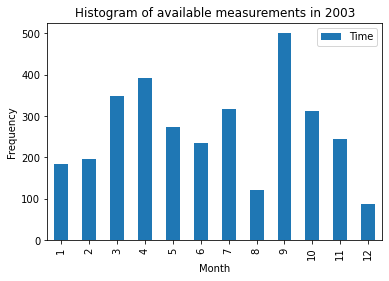

In [317]:
position_df['Time'].groupby(position_df["Time"].dt.month).count().plot(kind="bar", 
                                                               title=(f'Histogram of available measurements in {year}'),
                                                               xlabel='Month',
                                                               ylabel='Frequency', legend=True)

#### Convert to Web-Mercator for Plotting
Convert longitude and latitude to the Web-Mercator projection, which is needed to generate an interactive plot. 

In [318]:
proj_wgs84 = "epsg:4326"
proj_webm = "epsg:3857"

In [319]:
# Reproject positions in the position_df dataframe
position_df['Longitude'], position_df['Latitude'] = reproject(proj_wgs84, 
                                                              proj_webm, 
                                                              position_df['Latitude_WGS84'], # latitude 
                                                              position_df['Longitude_WGS84']) # longitude
position_df

,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS,Longitude,Latitude
Index_Relative,,,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0,5.137951e+05,8.569851e+06
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1,4.951825e+05,8.568256e+06
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2,4.770374e+05,8.568986e+06
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3,4.583024e+05,8.568143e+06
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4,4.394337e+05,8.569146e+06
...,...,...,...,...,...,...,...
945,15.6965,71.253998,2003-12-17 11:01:51,JH,3204,1.747326e+06,1.148968e+07
946,12.5057,71.252701,2003-12-17 22:14:57,JH,3205,1.392128e+06,1.148924e+07
947,13.0053,71.751503,2003-12-18 03:03:55,JH,3206,1.447743e+06,1.166426e+07


In [320]:
# dec03jan04 = pd.DataFrame()
# dec03jan04 = dec03jan04.append(position_df, ignore_index=True)
# dec03jan04

dec03jan04 = dec03jan04.append(position_df, ignore_index=True)
dec03jan04

,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS,Longitude,Latitude
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0,5.137951e+05,8.569851e+06
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1,4.951825e+05,8.568256e+06
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2,4.770374e+05,8.568986e+06
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3,4.583024e+05,8.568143e+06
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4,4.394337e+05,8.569146e+06
...,...,...,...,...,...,...,...
9584,15.6965,71.253998,2003-12-17 11:01:51,JH,3204,1.747326e+06,1.148968e+07
9585,12.5057,71.252701,2003-12-17 22:14:57,JH,3205,1.392128e+06,1.148924e+07
9586,13.0053,71.751503,2003-12-18 03:03:55,JH,3206,1.447743e+06,1.166426e+07
9587,14.9853,71.743301,2003-12-18 07:15:07,JH,3207,1.668156e+06,1.166134e+07


In [321]:
position_df = dec03jan04

#### Plot Positions
Plot locations on an interactive plot, color-coded by platform of acquisition. The plot allows you to:
* hoover your mouse on a point to see platform, longitude and latitude 
* pan across the map 
* zoom by selection box
* zoom in and out 
* reset plot to starting view
* toggle off / on positions of specific platforms by clicking on respective names on the legend 

In [322]:
# Plot all locations (in Web Mercator projection)
xlim = (min(position_df['Longitude'])-1, max(position_df['Longitude'])+1)
ylim = (min(position_df['Latitude'])-1, max(position_df['Latitude'])+1)
title = f'All measurement points, Projection: {proj_webm}'
plotInteractive(position_df, title, 'Longitude', 'Latitude', xlim, ylim)

Loading BokehJS ...

Based on the interactive plot above, we can reflect on the distribution of the available data, in order to anticipate the effect of applying filters for optimising the data retrieval.

Some filtering decisions can be made, for example, on the bounding box of interest, the platforms to be selected, and the time range. 

### Filter Positions (based on *position_df*)
This section shows a few examples of data filtering by using the **LATITUDE**, **LONGITUDE** and **TIME** dimensions. First, the data is filtered by bounding box (BBOX). Subsequently, this data is further filtered using a time range.

#### Filter by BBOX
The BBOX boundaries must be entered in geographic coordinates (WGS84).

Format to use: minLong, maxLong, minLat, maxLat (eg: -4, 18, 42, 72) 

In [323]:
bbox_dict = {}

# bbox_dict['BBOX=North Sea'] = [-5, 15, 53, 60]
bbox_dict['User_AOI'] = [-20, 40, 50, 85] #[-4, 7, 57, 62] # Zoom South West, off-Norway

bbox_key = list(bbox_dict.keys())[0]
bbox = bbox_dict[bbox_key]

In [324]:
# Reproject BBOX
bbox_reprj_lat, bbox_reprj_long = reproject(proj_wgs84, 
                                            proj_webm, 
                                            bbox[2:], # latitude first
                                            bbox[:2]) # then longitude
bbox_repj = list(np.array([bbox_reprj_lat, bbox_reprj_long]).flatten())

# Update bbox_dict
bbox_dict[bbox_key] = bbox_repj

In [325]:
# Now remove the ouliers outside bbox
position_df_bbox = position_df[(position_df.loc[:,'Longitude'] >= bbox_repj[0]) & 
                               (position_df.loc[:,'Longitude'] <= bbox_repj[1]) & 
                               (position_df.loc[:,'Latitude'] >= bbox_repj[2]) & 
                               (position_df.loc[:,'Latitude'] <= bbox_repj[3])]

# Print filtering results on original dataframe
print('Year:', year)
print('BBOX:', bbox_key)
sel_outof_all = f'{len(position_df_bbox)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')

display(position_df_bbox)

#print(position_df_bbox.index) # You can use the display(data[var].data[:][position_df_bbox.index]) to select the physical variables values of only those points within specific bbox

title = f'Filtered data: {bbox_key}'
plotInteractive(position_df_bbox, title, 'Longitude', 'Latitude', xlim, ylim, bbox_dict=bbox_dict)

Year: 2003
BBOX: User_AOI
Selected positions (out of available positions): 9474 out of 9589.


,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS,Longitude,Latitude
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0,5.137951e+05,8.569851e+06
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1,4.951825e+05,8.568256e+06
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2,4.770374e+05,8.568986e+06
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3,4.583024e+05,8.568143e+06
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4,4.394337e+05,8.569146e+06
...,...,...,...,...,...,...,...
9584,15.6965,71.253998,2003-12-17 11:01:51,JH,3204,1.747326e+06,1.148968e+07
9585,12.5057,71.252701,2003-12-17 22:14:57,JH,3205,1.392128e+06,1.148924e+07
9586,13.0053,71.751503,2003-12-18 03:03:55,JH,3206,1.447743e+06,1.166426e+07
9587,14.9853,71.743301,2003-12-18 07:15:07,JH,3207,1.668156e+06,1.166134e+07


Loading BokehJS ...

#### Filter by BBOX, adding Time Range filter

In [326]:
# Define here start and end date in the format [day,month,year]
time_start = [1,12,2003] 
time_end = [31,1,2004] 

In [327]:
time_start = datetime(time_start[2], time_start[1], time_start[0])
time_end = datetime(time_end[2], time_end[1], time_end[0])

position_df_bbox_timerange = position_df_bbox.loc[(position_df_bbox['Time']>=time_start) & 
                                                  (position_df_bbox['Time']<=time_end)]

# Print filtering results on original dataframe
print('Year:', year)
print('BBOX:', bbox_key)
time_filter_str = f'{time_start.strftime("%Y%m%d")}-{time_end.strftime("%Y%m%d")}'
print(f'Time Filter: {time_filter_str}')
sel_outof_all = f'{len(position_df_bbox_timerange)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')

display(position_df_bbox_timerange)

title = f'Filtered data: {bbox_key} and Time={time_filter_str}'
plotInteractive(position_df_bbox_timerange, title, 'Longitude', 'Latitude', xlim, ylim, bbox_dict)

Year: 2003
BBOX: User_AOI
Time Filter: 20031201-20040131
Selected positions (out of available positions): 250 out of 9589.


,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS,Longitude,Latitude
647,5.0987,61.916801,2003-12-01 06:06:42,AA,647,5.675847e+05,8.839442e+06
648,5.3507,62.132198,2003-12-01 15:04:22,AA,648,5.956372e+05,8.890557e+06
649,5.4582,62.091702,2003-12-01 16:25:02,AA,649,6.076040e+05,8.880920e+06
650,5.5118,62.060001,2003-12-01 17:00:58,AA,650,6.135707e+05,8.873384e+06
651,5.5007,62.035301,2003-12-01 17:28:26,AA,651,6.123351e+05,8.867518e+06
...,...,...,...,...,...,...,...
9584,15.6965,71.253998,2003-12-17 11:01:51,JH,3204,1.747326e+06,1.148968e+07
9585,12.5057,71.252701,2003-12-17 22:14:57,JH,3205,1.392128e+06,1.148924e+07
9586,13.0053,71.751503,2003-12-18 03:03:55,JH,3206,1.447743e+06,1.166426e+07
9587,14.9853,71.743301,2003-12-18 07:15:07,JH,3207,1.668156e+06,1.166134e+07


Loading BokehJS ...

#### Print or Export Filtered Positions
Uncomment the rows below if you want to display or export to CSV the filtered dataframe.

In [328]:
# # Print filtered dataframe
# pd.set_option('display.max_rows', None) # pd.set_option('display.max_rows', 10) # to restore first- and last- 5 rows to display
# display(position_df_bbox_timerange)

# # Save dataframe to csv
# data_output = os.path.join(os.getcwd(), 'data_output')
# if not os.path.exists(data_output): os.mkdir(data_output)
# csvname = os.path.join(data_output, f'filtered_{pc}_df.csv')
# position_df_bbox_timerange.to_csv(csvname, sep=',', header=True)

#### Zoom in on Filtered Positions
Plot filtered positions with the relavite extent of those positions only.

In [329]:
xlim_small = (min(position_df_bbox_timerange['Longitude'])-1, max(position_df_bbox_timerange['Longitude'])+1)
ylim_small = (min(position_df_bbox_timerange['Latitude'])-1, max(position_df_bbox_timerange['Latitude'])+1)
title = f'Filtered data: {bbox_key} and Time={time_filter_str}'
plotInteractive(position_df_bbox_timerange, title, 'Longitude', 'Latitude', xlim_small, ylim_small)

Loading BokehJS ...

#### Define Filtered Dataframe (*df_toPlot*) to be used for online querying of the filtered positions
Define the filtered dataframe (eg *position_df_bbox*, *position_df_bbox_timerange*), to be named **df_toPlot**, and the dictionary of indices of filtered data (to be named **index_dict**), to use for further filtering.

In [334]:
# Define dataframe to plot based on one of the previously defined filters
df_toPlot = position_df_bbox_timerange # or position_df / position_df_bbox

sel_outof_all = f'{len(df_toPlot)} / {len(position_df)}.'

print(f'- Filters: "BBOX={bbox_key}" and "Time={time_filter_str}"\n- Filtered / All (out of available positions): {sel_outof_all}')

display(df_toPlot)

# Dictionary of indices
index_dict = {}

for pc in df_toPlot['Platform'].unique():
    index_dict[pc] = df_toPlot[df_toPlot['Platform']==pc].index.tolist()

index_dict

- Filters: "BBOX=User_AOI" and "Time=20031201-20040131"
- Filtered / All (out of available positions): 250 / 9589.


,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS,Longitude,Latitude
647,5.0987,61.916801,2003-12-01 06:06:42,AA,647,5.675847e+05,8.839442e+06
648,5.3507,62.132198,2003-12-01 15:04:22,AA,648,5.956372e+05,8.890557e+06
649,5.4582,62.091702,2003-12-01 16:25:02,AA,649,6.076040e+05,8.880920e+06
650,5.5118,62.060001,2003-12-01 17:00:58,AA,650,6.135707e+05,8.873384e+06
651,5.5007,62.035301,2003-12-01 17:28:26,AA,651,6.123351e+05,8.867518e+06
...,...,...,...,...,...,...,...
9584,15.6965,71.253998,2003-12-17 11:01:51,JH,3204,1.747326e+06,1.148968e+07
9585,12.5057,71.252701,2003-12-17 22:14:57,JH,3205,1.392128e+06,1.148924e+07
9586,13.0053,71.751503,2003-12-18 03:03:55,JH,3206,1.447743e+06,1.166426e+07
9587,14.9853,71.743301,2003-12-18 07:15:07,JH,3207,1.668156e+06,1.166134e+07


{'AA': [647,
  648,
  649,
  650,
  651,
  652,
  653,
  654,
  655,
  656,
  657,
  658,
  659,
  660,
  661,
  662,
  663,
  664,
  665,
  666,
  667,
  668,
  669,
  670,
  671,
  672,
  673,
  674,
  675,
  676,
  677,
  678,
  679,
  680,
  681,
  682,
  683,
  7027,
  7028,
  7029,
  7030,
  7031,
  7032,
  7033,
  7034,
  7035,
  7036,
  7037,
  7038,
  7039,
  7040,
  7041,
  7042,
  7043,
  7044,
  7045,
  7046,
  7047,
  7048,
  7049,
  7050,
  7051,
  7052,
  7053,
  7054,
  7055,
  7056,
  7057,
  7058,
  7059,
  7060,
  7061,
  7062,
  7063],
 'GS': [1063,
  1064,
  1065,
  1066,
  1067,
  1068,
  1069,
  1070,
  1071,
  1072,
  1073,
  1074,
  1075,
  1076,
  1077,
  1078,
  1079,
  1080,
  1081,
  1082,
  1083,
  1084,
  1085,
  1086,
  1087,
  1088,
  4415,
  4416,
  4417,
  4418,
  4419,
  4420,
  4421,
  4422,
  4423,
  4424,
  7443,
  7444,
  7445,
  7446,
  7447,
  7448,
  7449,
  7450,
  7451,
  7452,
  7453,
  7454,
  7455,
  7456,
  7457,
  7458,
  7459,
  7460,


In [335]:
# display(df_toPlot[df_toPlot['Platform']=='JH'])
df_toPlot

,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS,Longitude,Latitude
647,5.0987,61.916801,2003-12-01 06:06:42,AA,647,5.675847e+05,8.839442e+06
648,5.3507,62.132198,2003-12-01 15:04:22,AA,648,5.956372e+05,8.890557e+06
649,5.4582,62.091702,2003-12-01 16:25:02,AA,649,6.076040e+05,8.880920e+06
650,5.5118,62.060001,2003-12-01 17:00:58,AA,650,6.135707e+05,8.873384e+06
651,5.5007,62.035301,2003-12-01 17:28:26,AA,651,6.123351e+05,8.867518e+06
...,...,...,...,...,...,...,...
9584,15.6965,71.253998,2003-12-17 11:01:51,JH,3204,1.747326e+06,1.148968e+07
9585,12.5057,71.252701,2003-12-17 22:14:57,JH,3205,1.392128e+06,1.148924e+07
9586,13.0053,71.751503,2003-12-18 03:03:55,JH,3206,1.447743e+06,1.166426e+07
9587,14.9853,71.743301,2003-12-18 07:15:07,JH,3207,1.668156e+06,1.166134e+07


In [ ]:
Up to here is comparable to the execution "extractor-tool --depth 25 --bbox "-20, 40, 50, 85" --time1 20031201 --time2 20040131 --vars 'TEMP' --format 'csv'"

## Data Processing: Load and Plot selected Data (Variables within DEPTH range)

This section enables fetching data of **selected variables** and **within a specified DEPTH range**, to avoid downloading unnecessary data and minimise data volume.

The list of variables need to be specified in the *vars_sel* variable. The four CTD physical variables that are available in this dataset (from OPeNDAP DDS information) are: 
* **PRES**: Sea Water Pressure
* **TEMP**: Sea Water Temperature
* **PSAL**: Sea Water Practical Salinity
* **CNDC**: Sea Water Electrical Conductivity 

The depth range must also be defined. For some limitations of the DAP syntax, at least one range boundary needs to correspond to one of the two extremes. For example, in a data array of 100 elements starting from 0 to 99, the following scenarios are possible:
* select the first 20 elements, corresponding to the values range 0 - 19 --> ```[first:1:intermediate] (eg [0:1:19])``` work
* select the last 20 elements, corresponsing to the values range 80 - 99 --> ```[intermediate:1:last] (eg [80:1:99])``` work
* select the intermediate 60-80 elements, corresponsing to the values range 60 - 79 --> ```[intermediate_1:1:intermediate_2] (eg [80:1:89])``` does NOT work

### Data Extraction
The CTD data is extracted based on the following parameters: Variables, Depth range, and Platform code. 

Afterwards, an additional filtering is applied based on the list of indices that will be extracted from the dictionary of positions (*df_toPlot*). 

#### Define Parameters

In [336]:
# Define Variable(s)
vars_main = ['PRES', 'TEMP', 'PSAL', 'CNDC'] 

# Define the selection of variable to use for the analysis
vars_sel = ['TEMP']#, 'PRES'] #, 'CNDC', 'PSAL']; 
assert all([elem in vars_main for elem in vars_sel])

In [337]:
# Define depths limits
depth1 = 25
depth2 = 25

In [338]:
# Define Platform(s) - Select either one of the two options below  

#================================================
# Option A) Use data from ALL available platforms
pc_sel = df_toPlot['Platform'].unique()

# Option B) Use data from only ONE platform
# pc_sel = ['AA']; assert pc_sel in df_toPlot['Platform'].unique(), 'ERROR: platform not available in given year.'
#================================================

# Create string for output name
if len(pc_sel) == 1: pc_str = pc_sel[0]
else: pc_str = "-".join(pc_sel)
    
# Print selection
print(f'Platform(s) selected: {pc_str}')

Platform(s) selected: AA-GS-JH


#### Create **data_dict** dictionary 
Data and their attributes are read iteratively for selected platform(s), and saved into a dictionary *data_dict* which contains:
* the actual data, loaded into an **xarray** for data handling, analysis and visualisation
* the campaign's main attributes: platform code & name, data type, title, instrument, longitude & latitude, and vertical min & max.

In [340]:
years = [2003, 2004]

In [341]:
dds_year_dict

NameError: name 'dds_year_dict' is not defined

In [23]:
for year in years:
    
    # Extract all platform_codes for that year
    pc_sel = [pc for pc in dds_year_dict[year].keys()]
    print(f'Working on year: {year} - Available platforms: {pc_sel}')
        
    
    
    data_dict = {}
    metadata = {}

    for pc in pc_sel:

        metadata[pc] = {}

        v_min = int(float(position_dict[pc]['data_attr'][6]))
        metadata[pc]['vmin'] = v_min
        metadata[pc]['depth_abs_v1'] = 0 # this is fixed
        metadata[pc]['depth_abs_v2'] = pc_dim_dict[pc]['DEPTH'] # this is fixed

        # ==============================================================================
        """
        Define here the DEPTH range of your selection, in meters. Note that either:
        - 'depth_m_v1' is equal to the lower bound (ie index=0), or 
        - 'depth_m_v2' is equal to the upper bound (ie index=-1)
        """
        metadata[pc]['depth_m_v1'] = 0 # depth1
        metadata[pc]['depth_m_v2'] = depth2 # pc_dim_dict[pc]['DEPTH']
        # ==============================================================================

        # assert metadata[pc]['depth_m_v1'] < metadata[pc]['depth_m_v2'], 'ERROR: the lower bound must be lower than the higher bound' 
        # assert metadata[pc]['depth_m_v1'] == 0 or metadata[pc]['depth_m_v2'] == pc_dim_dict[pc]['DEPTH'], 'ERROR: one of the two values must be equal to one of the lower/upper bounds'

        #     print(f'DEPTH range of interest (meters): {metadata[pc]["depth_m_v1"]} - {metadata[pc]["depth_m_v2"]}')

        # the start and stop values are adjusted based on the vmin value
        if metadata[pc]['vmin'] == 1: 
            if metadata[pc]['depth_m_v1'] == 0: # 
                metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1'] # the same
                metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2'] # the same, so I have the right size. When I shift and add the nan, I get rid of further element on the right
                metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2']# - 1

            elif metadata[pc]['depth_m_v1'] != 0: 
                metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1'] - 1 # start one element before
                metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2'] - 1 # last element is excluded, ie stop one element before. But then I'll have to remoove one element
                metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2'] - metadata[pc]['depth_m_v1'] - 1 

        else:
            metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1']
            metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2']

            if metadata[pc]['depth_m_v1'] == 0: # 
                metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2']

            elif metadata[pc]['depth_m_v1'] != 0: 
                metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2'] - metadata[pc]['depth_m_v1']

        metadata[pc]['depth_newindex4xr_v1'] = 0

        pprint.pprint(metadata[pc])
        print(f'{pc} DEPTH range of interest (adjusted with vmin): {metadata[pc]["depth_newindex_v1"]} - {metadata[pc]["depth_newindex_v2"]}')

        fix_lab = f'58{pc}_CTD_{year}' # platform_codes and year are defined at the beginning of the notebook 

        # Get coordinates (needed for keeping hte correct structure, and for plotting) 
        coords_str = getQueryString(pc_dim_dict[pc], keylist = ['TIME', 'LATITUDE', 'LONGITUDE']) # list the coordinates you want

        # Extract TIME and DEPTH dimension for queries 
        time_dims = getQuery(pc, start=0, stop=pc_dim_dict[pc]['TIME'])
        depth_dims = getQuery(pc, start=metadata[pc]['depth_newindex_v1'], stop=metadata[pc]['depth_newindex_v2'])#; print(depth_dims)

        # join TIME and DEPTH for Variables
        var_str_ALL = []
        for v in vars_sel: var_str_ALL = np.append(var_str_ALL, f'{v}{time_dims}{depth_dims}')
        queries_vars = ','.join(var_str_ALL)

        # Build url and url with queries (url_q)
        url = f'{url_info[0]}{fix_lab}.nc{url_info[1]}?{coords_str}' 
        url_q = f'{url},{queries_vars}'; print(f'Platform {pc} URL:', url_q)

        remote_data, data_attr = fetch_data(url_q, year)

        data_dict[pc] = {'data': remote_data, 
                         'data_attr': data_attr}

        print(f'{data_attr}\n')

    # display(data_dict)
    print(f'Checking the existing campaigns in the dictionary: {list(data_dict.keys())}')

{'depth_abs_v1': 0,
 'depth_abs_v2': 2809,
 'depth_m_v1': 0,
 'depth_m_v2': 25,
 'depth_newindex4xr_v1': 0,
 'depth_newindex4xr_v2': 25,
 'depth_newindex_v1': 0,
 'depth_newindex_v2': 25,
 'vmin': 0}
AA DEPTH range of interest (adjusted with vmin): 0 - 25
Platform AA URL: https://opendap.terradue.com/hyrax/data/subset_2003/58AA_CTD_2003.nc.nc4?TIME[0:1:683],LATITUDE[0:1:683],LONGITUDE[0:1:683],TEMP[0:1:683][0:1:25],PRES[0:1:683][0:1:25]
['58AA' 'H\\\\303\\\\245kon Mosby' '2003' 'OceanSITES vertical profile'
 'Arctic Ocean - In Situ Observation Copernicus' 'CTD Seabird' '0.000'
 '2811.000' '-11.884' '17.833' '53.996' '69.999']

{'depth_abs_v1': 0,
 'depth_abs_v2': 3683,
 'depth_m_v1': 0,
 'depth_m_v2': 25,
 'depth_newindex4xr_v1': 0,
 'depth_newindex4xr_v2': 25,
 'depth_newindex_v1': 0,
 'depth_newindex_v2': 25,
 'vmin': 1}
GS DEPTH range of interest (adjusted with vmin): 0 - 25
Platform GS URL: https://opendap.terradue.com/hyrax/data/subset_2003/58GS_CTD_2003.nc.nc4?TIME[0:1:404],LATIT

### Create Overview Dataframe with Platforms' Attributes
An overview dataframe *overview_df* is then generated to show the detailed information about each campaign at sea: platform code & name, data type, title, instrument, longitude & latitude, and vertical min & max).

In [24]:
# Create database with the selected campaigns & years
overview_df = pd.DataFrame()
overview_df = getAttributes(overview_df, data_dict)
overview_df

,Platform_code,Platform_name,Year,Data_type,Title,Instrument,Vertical_min,Vertical_max,Lon_min,Lon_max,Lat_min,Lat_max
AA,58AA,H\\303\\245kon Mosby,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,0.0,2811.0,-11.884,17.833,53.996,69.999
GS,58GS,G.O. Sars,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,3688.0,-17.979,22.532,59.280,78.336
GT,58GT,Sarsen,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,2962.0,-9.520,35.016,56.667,78.655


In [25]:
# Extract / define the variables to use for the analysis
print('\nPrinting DEPTH range for analyis:')
assert len(np.unique([metadata[k]["depth_m_v1"] for k in metadata.keys()])==1)
assert len(np.unique([metadata[k]["depth_m_v2"] for k in metadata.keys()])==1)

for k in data_dict.keys():
    print(f'{k}; DEPTH filtered: {metadata[k]["depth_m_v1"]}-{metadata[k]["depth_m_v2"]}m; VARS: {list(data_dict[k]["data"].variables)}')


Printing DEPTH range for analyis:
AA; DEPTH filtered: 0-25m; VARS: ['TIME', 'LATITUDE', 'LONGITUDE', 'PRES', 'TEMP']
GS; DEPTH filtered: 0-25m; VARS: ['TIME', 'LATITUDE', 'LONGITUDE', 'PRES', 'TEMP']
GT; DEPTH filtered: 0-25m; VARS: ['TIME', 'LATITUDE', 'LONGITUDE', 'PRES', 'TEMP']


In [26]:
# Generate vmin dictionary (needed to avoid doing the vmin adjustment more than once)
vmin_dict = {}

# select only those platforms where vmin == 1
vmin_pc = overview_df[overview_df['Vertical_min'] == 1.0].index

for i in vmin_pc:
    vmin_dict[i] = {}
    
    for v in vars_sel:
        vmin_dict[i][v] = False

vmin_dict   

{'GS': {'TEMP': False, 'PRES': False}, 'GT': {'TEMP': False, 'PRES': False}}

### Filter by DEPTH and selected Indices
Apply the previously defined selection of indices (filtered based on BBOX and Time Range), and add filtering by DEPTH range. 

The output of this operation is a *filtered_xarr_dict* dictionary containing xarray datasets for each platform, containing the variable at the specified DEPTH range

#### Data filtered by DEPTH

In [27]:
filtered_xarr_dict = {}

print(f'Selected range of DEPTH: {depth1} - {depth2}m\n')
for pc in data_dict.keys():

    # Generate a filtered xarray with all variables for selected Platform, for a certain DEPTH range
    if metadata[pc]['depth_m_v1']==0: align_and_nan = True
    else: align_and_nan = False

    for v in vars_sel: 
        check_alignment(data_dict, pc, v, align_and_nan, vmin_dict)

    filtered_xarr_dict[pc] = filter_xarr_DEPTH(df_toPlot, 
                                               data_dict,
                                               platform=pc,
                                               depth_range=[depth1, depth2])
    # display(filtered_xarr_dict[pc])

Selected range of DEPTH: 25 - 25m

Platform: AA; Vertical min: 0.0; Var: TEMP
Platform: AA; Vertical min: 0.0; Var: PRES
Platform: GS; Vertical min: 1.0; Var: TEMP --> aligning and add nan
Platform: GS; Vertical min: 1.0; Var: PRES --> aligning and add nan
Platform: GT; Vertical min: 1.0; Var: TEMP --> aligning and add nan
Platform: GT; Vertical min: 1.0; Var: PRES --> aligning and add nan


### Aggregation of Available Platforms
Two xarray datasets can be merged if they have the same structure, i.e. dimensions. First check the dimensions of DEPTH are the same.

In [28]:
# Dictionary of variables for each platform
data_var_dict = {}
depth_arr = []

for pc in data_dict.keys():
    
    data_var_dict[pc] = {}
    data = filtered_xarr_dict[pc]
    
    depth_dim_pc = data.dims["DEPTH"]
    depth_arr.append(depth_dim_pc)
    
    print(f'PC {pc}\tFiltered Dims: TIME={data.dims["TIME"]}, DEPTH={data.dims["DEPTH"]}')
    
    for var in vars_sel:
        data_var_dict[pc][var] = filtered_xarr_dict[pc][var]
        
assert all(x==depth_arr[0] for x in depth_arr), 'ERROR, the DEPTH dimensions must be equal.'
# display(data_var_dict)

PC AA	Filtered Dims: TIME=61, DEPTH=1
PC GS	Filtered Dims: TIME=129, DEPTH=1
PC GT	Filtered Dims: TIME=54, DEPTH=1


Now aggregate and plot each variable: on the y-axis is shown the TIME of the measurement (in float format, which needs to be converted to datetime format), and on the x-axis is the DEPTH of the measurement.

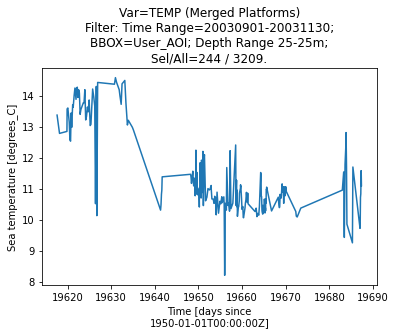

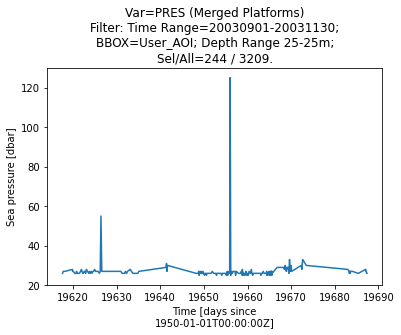

In [29]:
# Combine arrays across platforms, for each variable
merged_arr = {}

for var in vars_sel:
    
    merged_arr[var] = xr.merge([data_var_dict[pc][var] for pc in data_dict.keys()])  
        
    title = f'Var={var} (Merged Platforms)\nFilter: Time Range={time_filter_str};\nBBOX={bbox_key}; Depth Range {depth1}-{depth2}m;\nSel/All={sel_outof_all}'

    plotVar_MergedPlatforms(merged_arr[var], var, title=title)
    # display(merged_arr[var])

In [82]:
# Combine arrays across platforms, with ALL variables
merged_arr_vars = xr.merge([data_var_dict[pc][var] for pc in data_dict.keys() for var in vars_sel]) 
merged_arr_vars

<xarray.Dataset>
Dimensions:  (TIME: 244, DEPTH: 1)
Coordinates:
  * TIME     (TIME) float64 1.962e+04 1.962e+04 ... 1.969e+04 1.969e+04
Dimensions without coordinates: DEPTH
Data variables:
    TEMP     (TIME, DEPTH) float64 13.38 13.2 12.79 12.86 ... 11.59 11.42 11.11
    PRES     (TIME, DEPTH) float32 26.0 27.0 27.0 28.0 ... 27.0 26.0 26.0 26.0
Attributes:
    standard_name:        sea_water_temperature
    long_name:            Sea temperature
    units:                degrees_C
    valid_min:            -2500
    valid_max:            40000
    ancillary_variables:  TEMP_QC TEMP_DM
    data_mode:            M

In [83]:
m = merged_arr_vars.to_dataframe().reset_index()
m

,TIME,DEPTH,TEMP,PRES
0,19617.610752,0,13.381,26.0
1,19617.785162,0,13.204,27.0
2,19618.171725,0,12.791,27.0
3,19619.869965,0,12.855,28.0
4,19619.911632,0,13.580,27.0
...,...,...,...,...
239,19687.135058,0,10.726,27.0
240,19687.208438,0,10.837,27.0
241,19687.282350,0,11.589,26.0
242,19687.317697,0,11.423,26.0


In [98]:
m['DEPTH'] = depth1
m

,TIME,DEPTH,TEMP,PRES
0,19617.610752,25,13.381,26.0
1,19617.785162,25,13.204,27.0
2,19618.171725,25,12.791,27.0
3,19619.869965,25,12.855,28.0
4,19619.911632,25,13.580,27.0
...,...,...,...,...
239,19687.135058,25,10.726,27.0
240,19687.208438,25,10.837,27.0
241,19687.282350,25,11.589,26.0
242,19687.317697,25,11.423,26.0


In [94]:
m[['TIME','DEPTH','TEMP']].to_csv('/workspace/INTAROS/iaos-CTD-extract-from-opendap/exported_data/test_temp.csv')

In [55]:
data_dict['AA']['data'].isel(TIME=np.arange(0,2),
                             LATITUDE=np.arange(0,2),
                             LONGITUDE=np.arange(0,2),
                             DEPTH=np.arange(0,1)
                            )

<xarray.Dataset>
Dimensions:    (TIME: 2, LATITUDE: 2, LONGITUDE: 2, DEPTH: 1)
Coordinates:
  * TIME       (TIME) float64 1.936e+04 1.936e+04
  * LATITUDE   (LATITUDE) float32 60.76 60.75
  * LONGITUDE  (LONGITUDE) float32 4.615 4.448
Dimensions without coordinates: DEPTH
Data variables:
    PRES       (TIME, DEPTH) float32 1.0 0.0
    TEMP       (TIME, DEPTH) float64 6.312 6.861
Attributes: (12/141)
    title:                          Arctic Ocean - In Situ Observation Copern...
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        cmems-service@imr.no
    format_version:                 1.4
    distribution_statement:         These data follow Copernicus standards; t...
    citation:                       These data were collected and made freely...
    ...                             ...
    CNDC_DM._FillValue:              
    CNDC_DM.conventions:            Copernicus Marine In Situ reference table 1
    CNDC_DM.flag_values:            R, A, D
    CNDC_DM.flag_meanings:          real-time adjusted-in-real-time delayed-mode
    CNDC_DM.long_name:              Electrical conductivity method of data pr...
    CNDC_DM.string_length:          [2810, 2811]

In [44]:
data_dict['AA']['data'].isel(TIME=np.arange(0,2),
                             LATITUDE=np.arange(0,2),
                             LONGITUDE=np.arange(0,2),
                             DEPTH=np.arange(0,1)
                            ).to_dataframe()

PRES   TEMP
TIME         LATITUDE  LONGITUDE DEPTH             
19364.226354 60.755299 4.6155    0       1.0  6.312
                       4.4483    0       1.0  6.312
             60.748299 4.6155    0       1.0  6.312
                       4.4483    0       1.0  6.312
19364.253565 60.755299 4.6155    0       0.0  6.861
                       4.4483    0       0.0  6.861
             60.748299 4.6155    0       0.0  6.861
                       4.4483    0       0.0  6.861

In [57]:
data_var_dict[pc]['TEMP']

<xarray.DataArray 'TEMP' (TIME: 54, DEPTH: 1)>
array([[13.381],
       [13.204],
       [12.791],
       [12.855],
       [13.58 ],
       [13.61 ],
       [13.155],
       [12.588],
       [12.54 ],
       [13.45 ],
       [12.986],
       [13.714],
       [13.636],
       [14.011],
       [14.255],
       [13.89 ],
       [14.25 ],
       [14.281],
       [13.951],
       [14.198],
...
       [14.223],
       [13.946],
       [13.673],
       [10.522],
       [14.307],
       [10.136],
       [14.435],
       [14.378],
       [14.59 ],
       [14.438],
       [14.2  ],
       [14.012],
       [13.729],
       [14.39 ],
       [14.5  ],
       [13.757],
       [13.062],
       [13.214],
       [12.988],
       [12.901]])
Coordinates:
  * TIME     (TIME) float64 1.962e+04 1.962e+04 ... 1.963e+04 1.964e+04
Dimensions without coordinates: DEPTH
Attributes:
    standard_name:        sea_water_temperature
    long_name:            Sea temperature
    units:                degrees_C
    valid_min:            -2500
    valid_max:            40000
    ancillary_variables:  TEMP_QC TEMP_DM
    data_mode:            D

In [46]:
merged_arr

{'TEMP': <xarray.Dataset>
 Dimensions:  (TIME: 244, DEPTH: 1)
 Coordinates:
   * TIME     (TIME) float64 1.962e+04 1.962e+04 ... 1.969e+04 1.969e+04
 Dimensions without coordinates: DEPTH
 Data variables:
     TEMP     (TIME, DEPTH) float64 13.38 13.2 12.79 12.86 ... 11.59 11.42 11.11
 Attributes:
     standard_name:        sea_water_temperature
     long_name:            Sea temperature
     units:                degrees_C
     valid_min:            -2500
     valid_max:            40000
     ancillary_variables:  TEMP_QC TEMP_DM
     data_mode:            M,
 'PRES': <xarray.Dataset>
 Dimensions:  (TIME: 244, DEPTH: 1)
 Coordinates:
   * TIME     (TIME) float64 1.962e+04 1.962e+04 ... 1.969e+04 1.969e+04
 Dimensions without coordinates: DEPTH
 Data variables:
     PRES     (TIME, DEPTH) float32 26.0 27.0 27.0 28.0 ... 27.0 26.0 26.0 26.0
 Attributes:
     axis:                 Z
     uncertainty:           
     comment:               
     ancillary_variables:  PRES_QC
     standard

To Recap:
* ```data_dict[pc]['data']```: contains the xarray extracted from the url (eg from **0** to **depth2**, for ALL locations)
* ```filtered_xarr```: contains the xarray filtered from ```data_dict[pc]['data']``` (ie from **depth1** to **depth2**, for filtered locations (BBOX and time_range))

### Export to File

In [69]:
# Output dir
data_output = os.path.join(os.getcwd(), 'data_output')
if not os.path.exists(data_output): os.mkdir(data_output)

# File name (without file extension)
fname = os.path.join(data_output, 
                     f'Scientist_pc={pc_str}_BBOX={bbox_key}_MMYYYY={time_filter_str}_d={depth1}-{depth2}m_var={"_".join(vars_sel)}')

#### Export to NetCDF

In [73]:
# Export to NetCDF
netcdfname = fname + '.nc.nc4'
merged_arr['TEMP'].to_netcdf(path=netcdfname,
                             mode='w')

#### Export to CSV
##### Create Dataframe of Filtered XARRAY
This step is implemented to generate a CSV-structured dataframe, to then export to a CSV file, which is the input expected by the RGeostats module.

In [32]:
# Create dataframe with filtered data and columns ['LATITUDE', 'LONGITUDE', 'TIME', 'TEMP', 'DEPTH']
filtered2csv_multiDepths = pd.DataFrame() 

for pc in data_dict.keys():

    for d in range(depth1, depth2+1):

        # Create temporary dataframe
        temp = pd.DataFrame()

        data_depth_sel = data_dict[pc]['data'].isel(TIME=index_dict[pc],
                                                    LATITUDE=index_dict[pc],
                                                    LONGITUDE=index_dict[pc],
                                                    DEPTH=slice(d, d+1))

        for col in ['LONGITUDE', 'LATITUDE', 'TIME']:
            temp[col.title()] = data_depth_sel[col].data.astype(float) 

        if 'TEMP' in vars_sel: temp['Temperature'] = data_depth_sel['TEMP'].data.astype(float) 
        if 'CNDC' in vars_sel: temp['Conductivity'] = data_depth_sel['CNDC'].data.astype(float) 
        if 'PSAL' in vars_sel: temp['Salinity'] = data_depth_sel['PSAL'].data.astype(float) 

        temp['Depth'] = d 
        temp['Vessel_name'] = pc 

        filtered2csv_multiDepths = filtered2csv_multiDepths.append(temp, ignore_index=True)
    
# Rename index column with 'rank'
filtered2csv_multiDepths = filtered2csv_multiDepths.rename_axis("rank")

display(filtered2csv_multiDepths)

,Longitude,Latitude,Time,Temperature,Depth,Vessel_name
rank,,,,,,
0,5.3070,61.081501,19649.426551,9.350,0,AA
1,5.3070,61.081501,19649.456597,9.282,0,AA
2,5.5597,60.870701,19650.209329,10.699,0,AA
3,5.3862,60.871799,19650.403171,10.088,0,AA
4,5.4713,60.882000,19650.647697,10.698,0,AA
...,...,...,...,...,...,...
12439,1.4820,57.785301,19633.395799,9.676,50,GT
12440,0.5797,57.749298,19633.728692,13.053,50,GT
12441,0.5003,57.240501,19633.933576,13.135,50,GT


##### Assign *Profil_id* to the unique positions

In [33]:
# find pair of unique coordinates 
unique_pos = filtered2csv_multiDepths.groupby(['Longitude','Latitude']).size().reset_index().rename(columns={0:'count'})

prof_id = 1
for long, lat in zip(unique_pos['Longitude'], unique_pos['Latitude']):
    
    # Define condition
    cond = (filtered2csv_multiDepths['Longitude'] == long) & (filtered2csv_multiDepths['Latitude'] == lat)
#     display(filtered2csv_multiDepths.loc[cond])
    
    # Assign unique Profil_id 
    filtered2csv_multiDepths.loc[cond,'Profil_id'] = prof_id
    prof_id += 1

# Convert to integer
filtered2csv_multiDepths = filtered2csv_multiDepths.astype({'Profil_id': int})
display(filtered2csv_multiDepths)

,Longitude,Latitude,Time,Temperature,Depth,Vessel_name,Profil_id
rank,,,,,,,
0,5.3070,61.081501,19649.426551,9.350,0,AA,200
1,5.3070,61.081501,19649.456597,9.282,0,AA,200
2,5.5597,60.870701,19650.209329,10.699,0,AA,215
3,5.3862,60.871799,19650.403171,10.088,0,AA,206
4,5.4713,60.882000,19650.647697,10.698,0,AA,211
...,...,...,...,...,...,...,...
12439,1.4820,57.785301,19633.395799,9.676,50,GT,71
12440,0.5797,57.749298,19633.728692,13.053,50,GT,47
12441,0.5003,57.240501,19633.933576,13.135,50,GT,41


In [74]:
# Export dataframe to CSV
csvname = fname + '.csv'
filtered2csv_multiDepths.to_csv(csvname, sep=',', header=True)
print('Output filename:', csvname)

Output filename: /workspace/INTAROS/iaos-showcase-app-Barents-Sea-CTD/data_output/Scientist_pc=AA-GS-GT_BBOX=User_AOI_MMYYYY=20030901-20031130_d=0-50m_var=TEMP.csv


### Plot Histogram of measurements of filtered data

<AxesSubplot:xlabel='Month & Day', ylabel='Count'>

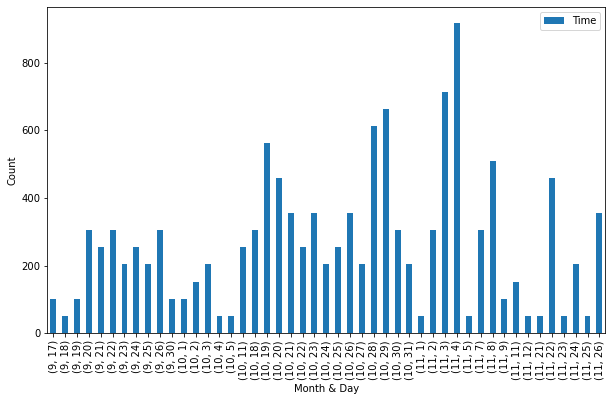

In [35]:
# Create a copy (I need to keep the original as it is, because Time needs to be a floating number)
filtered2csv_multiDepths_time = filtered2csv_multiDepths.copy()

# Convert Time from float to datetime
filtered2csv_multiDepths_time['Time'] = [start_date + timedelta(t) for t in filtered2csv_multiDepths_time.loc[:,'Time']]

# Plot Histogram
filtered2csv_multiDepths_time["Time"].groupby([filtered2csv_multiDepths_time["Time"].dt.month,
                                               filtered2csv_multiDepths_time["Time"].dt.day]).count().plot(figsize=(10,6),
                                                                                                           kind="bar", 
                                                                                                           legend=True, 
                                                                                                           xlabel='Month & Day', 
                                                                                                           ylabel='Count')